### **거래 흐름 기반 유동성(Liquidity) 및 경로(Pathway) 분석**

**유동성(Liquidity) 분석**

데이터베이스 분석에서 유동성 분석을 직접적으로 활용하는 사례는 드물지만, 데이터베이스 자체의 성능 최적화나 **데이터 기반 의사결정을 지원**하는 맥락에서 간접적으로 관련될 수 있습니다. 유동성 분석은 주로 기업의 재무 건전성, 특히 단기 채무 상환 능력을 평가하는 데 사용되는 재무 지표입니다.

->기업의 재무 건전성을 평가하고, 잠재적 위험을 예측하며, 더 나은 비즈니스 의사결정을 지원하는 데 간접적으로 활용될 수 있습니다

**경로(pathway)분석**

경로 분석은 데이터베이스 내의 복잡한 관계와 흐름을 이해하는 데 강력한 도구입니다. 사용자 행동 분석부터 시스템 내부의 데이터 이동, 복잡한 인과 관계 추론에 이르기까지 다양한 영역에서 적용 가능하며, 적절한 분석 도구와 방법론을 활용하여 데이터 기반의 인사이트를 도출하고 의사 결정을 지원할 수 있습니다.

-> **사용자 행동 여정을 분석**
-> **시스템 및 네트워크 분석**

---

1. 사용자 간 자금 흐름(Network Pathway) 시각화
2. 반복적 송금 경로 및 비정상 자금 순환 탐지
3. 사기 계정 중심의 거래 연결 구조 분석

전체 자금 흐름 중 거래 금액이 큰 주요 통로 위주로 네트워크 경로 분석

-  계좌(nameOrig, nameDest)를 점(Node)으로, 거래(amount)를 선(Edge)으로 설정
- 어떤 계좌가 자금 세탁의 거점(Hub) 역할을 하는지 페이지랭크(PageRank) 알고리즘으로 찾아냄

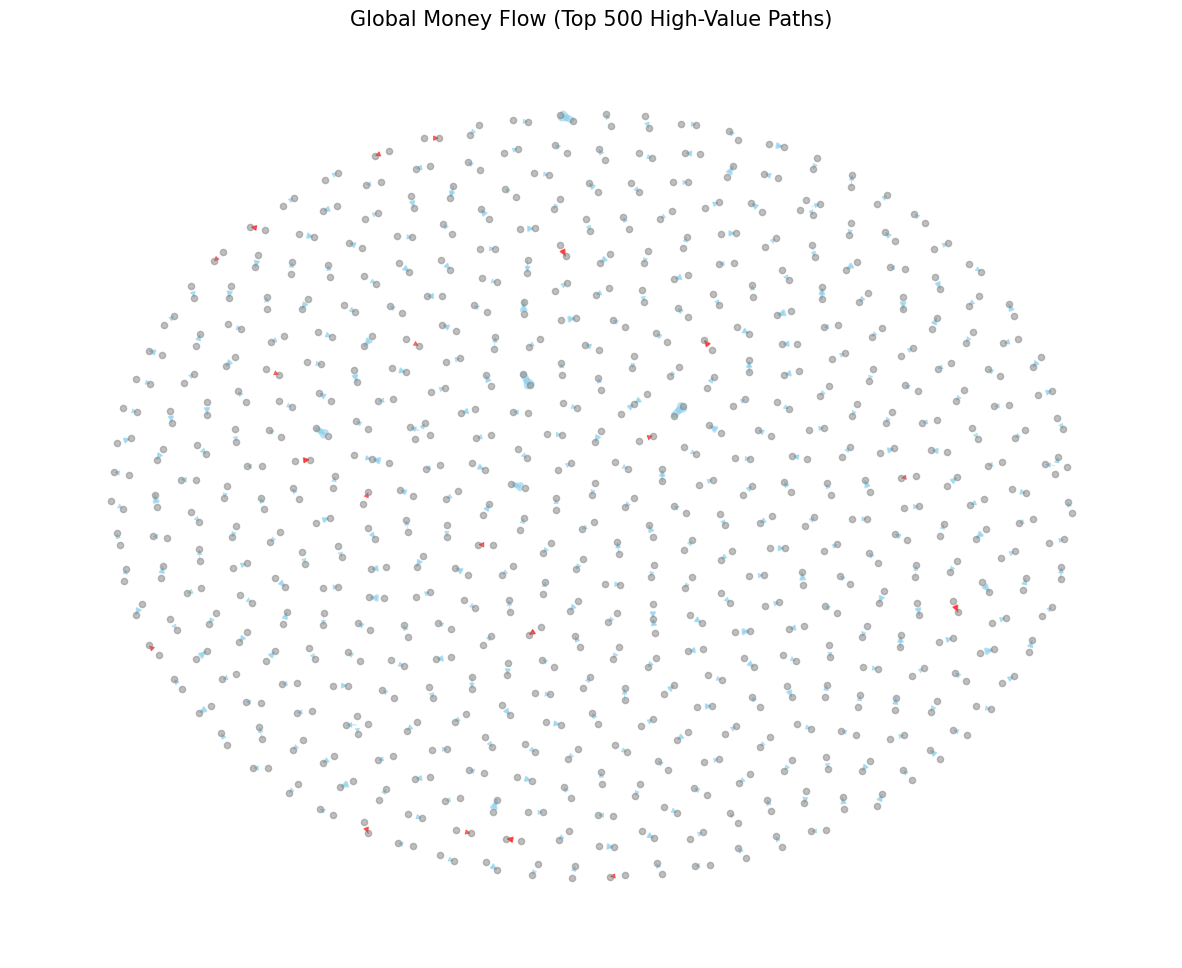

In [23]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# 1. 전체 자금 흐름 중 금액 기준 상위 500개 경로 추출
# (DB 엔진이 연결되어 있다고 가정합니다)
query_global = """
SELECT nameOrig, nameDest, amount, isFraud
FROM PaySim
ORDER BY amount DESC
LIMIT 500;
"""
df_global = pd.read_sql(query_global, engine)

# 2. 그래프 생성
G_global = nx.from_pandas_edgelist(
    df_global, 
    source='nameOrig', 
    target='nameDest', 
    edge_attr=['amount', 'isFraud'],
    create_using=nx.DiGraph()
)

# 3. 시각화 함수 (전체 흐름용)
def plot_global_network(G):
    plt.figure(figsize=(15, 12))
    # 전체 흐름은 circular_layout이나 shell_layout이 구조 파악에 좋을 때가 있습니다.
    pos = nx.spring_layout(G, k=0.2, iterations=50)
    
    edges = G.edges(data=True)
    # 사기가 포함된 경로는 빨간색, 일반 고액 거래는 파란색 계열
    colors = ['red' if d['isFraud'] == 1 else 'skyblue' for u, v, d in edges]
    # 금액에 비례하여 선 두께 조절 (시각적 직관성)
    max_amount = df_global['amount'].max()
    widths = [(d['amount'] / max_amount) * 5 for u, v, d in edges]

    nx.draw_networkx_nodes(G, pos, node_size=20, node_color='grey', alpha=0.5)
    nx.draw_networkx_edges(G, pos, edge_color=colors, width=widths, alpha=0.6, arrowsize=8)
    
    plt.title("Global Money Flow (Top 500 High-Value Paths)", fontsize=15)
    plt.axis('off')
    plt.show()

# 실행
plot_global_network(G_global)


전체 데이터를 다 그리면 너무 복잡하므로, 사기 거래(isFraud=1)와 그에 연계된 계좌들만 추출하여 분석

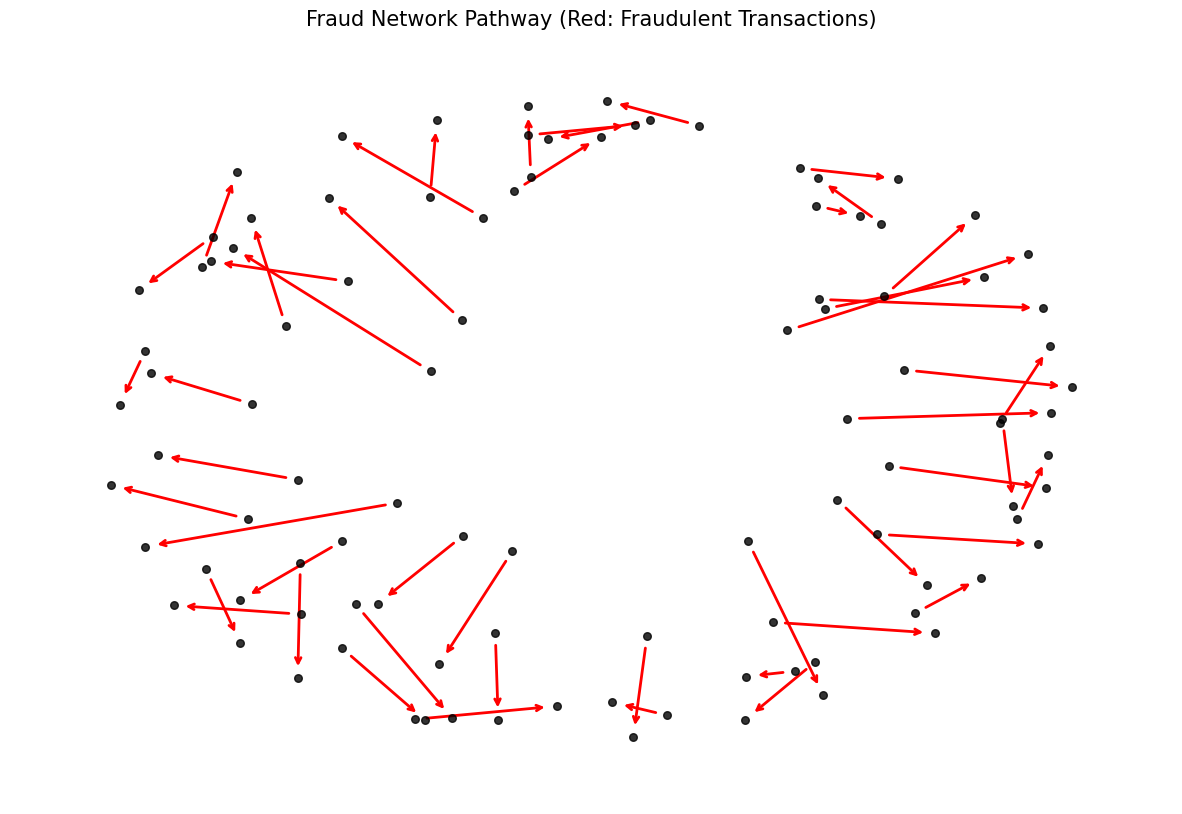

발견된 자금 순환 경로 수: 0
자금 유입 거점(Hub) 계좌 상위 5:
계좌: C2085820540, 집중도 점수: 0.0130
계좌: C1519845212, 집중도 점수: 0.0130
계좌: C639921569, 집중도 점수: 0.0130
계좌: C1318550066, 집중도 점수: 0.0130
계좌: C1229046559, 집중도 점수: 0.0130


In [21]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# 1. 데이터 마트에서 사기 관련 데이터만 로드
# 저장했던 csv 파일에서 사기 거래 및 그와 연결된 거래만 필터링합니다.
df_mart = pd.read_csv('../datasets/paysim_data_mart.csv')
fraud_nodes = df_mart[df_mart['isFraud'] == 1]['nameOrig'].unique()[:50] # 샘플링
df_sub = df_mart[df_mart['nameOrig'].isin(fraud_nodes) | df_mart['nameDest'].isin(fraud_nodes)]

# 2. 방향성 그래프 생성 (자금의 흐름 추적)
G = nx.from_pandas_edgelist(
    df_sub, 
    source='nameOrig', 
    target='nameDest', 
    edge_attr=['amount', 'isFraud'],
    create_using=nx.DiGraph()
)

# 3. 네트워크 시각화 함수
def plot_fraud_network(G):
    plt.figure(figsize=(15, 10))
    pos = nx.spring_layout(G, k=0.3) # 노드 간 거리를 조절하는 레이아웃
    
    # 사기 거래 엣지는 빨간색, 정상 거래는 회색으로 설정
    edges = G.edges(data=True)
    colors = ['red' if d['isFraud'] == 1 else 'lightgrey' for u, v, d in edges]
    widths = [2 if d['isFraud'] == 1 else 0.5 for u, v, d in edges]
    
    # 그래프 그리기
    nx.draw_networkx_nodes(G, pos, node_size=30, node_color='black', alpha=0.8)
    nx.draw_networkx_edges(G, pos, edge_color=colors, width=widths, arrowstyle='->', arrowsize=10)
    
    plt.title("Fraud Network Pathway (Red: Fraudulent Transactions)", fontsize=15)
    plt.axis('off')
    plt.show()

# 4. 순환 경로(Cycle) 및 거점 탐지
def detect_laundering_patterns(G):
    # 자금 세탁 패턴: A -> B -> C -> A와 같은 순환 탐지
    cycles = list(nx.simple_cycles(G))
    # 자금이 모이는 거점 계좌 분석
    centrality = nx.pagerank(G, weight='amount')
    top_hubs = sorted(centrality.items(), key=lambda x: x[1], reverse=True)[:5]
    
    print(f"발견된 자금 순환 경로 수: {len(cycles)}")
    print("자금 유입 거점(Hub) 계좌 상위 5:")
    for hub, score in top_hubs:
        print(f"계좌: {hub}, 집중도 점수: {score:.4f}")

# 실행
plot_fraud_network(G)
detect_laundering_patterns(G)

    - 해석
노드(계좌)들이 서로 멀리 떨어져 있고 매우 단순한 일대일(1:1) 혹은 일대다(1:N) 형태의 짧은 경로만 반복적으로 나타남

더 의미있는 경로를 위한 수정
- 단순히 사기 거래 상위 100건이 아니라, 최소 2단계 이상 연결된 거래를 가져오도록 쿼리 로직을 집중
- 노드 간 거리를 좁히고 연결을 강조하기 위해 k 값(탄성)을 조절

In [11]:
# 사기 계정과 직접 거래했거나, 그 거래 대상과 또 거래한 계좌들 위주로 추출
query_complex_path = """
WITH FraudRelated AS (
    SELECT DISTINCT nameOrig FROM PaySim WHERE isFraud = 1 LIMIT 20
)
SELECT p.nameOrig, p.nameDest, p.amount, p.isFraud
FROM PaySim p
JOIN FraudRelated f ON p.nameOrig = f.nameOrig OR p.nameDest = f.nameOrig
LIMIT 1000;
"""
from sqlalchemy import create_engine
engine = create_engine("sqlite:///paysim.db")
df_path = pd.read_sql(query_complex_path, engine)

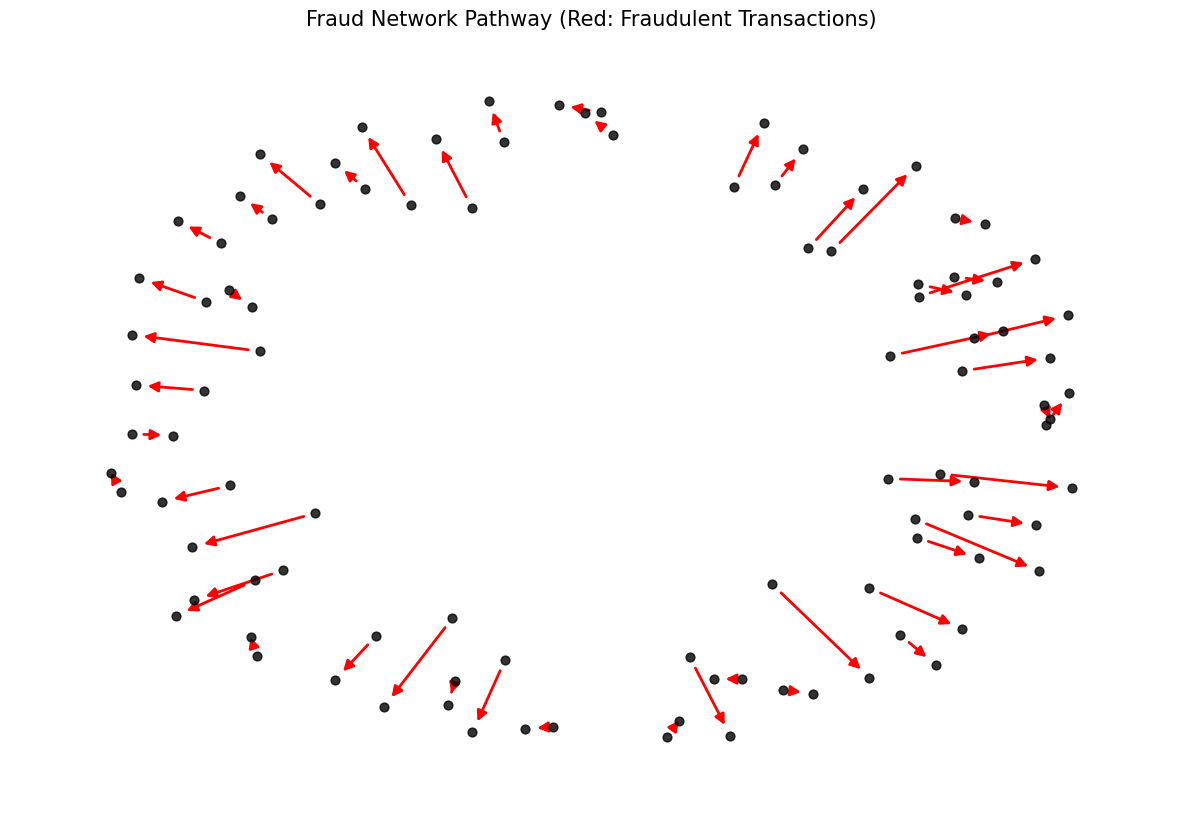

In [17]:
import networkx as nx
import matplotlib.pyplot as plt

# 1. 그래프 레이아웃 설정 (k값을 조절해 노드 간격을 좁힘)
pos = nx.spring_layout(G, k=0.15, iterations=50, seed=42) 

# 2. 엣지(선)의 색상과 두께 정의
# 데이터프레임에서 넘겨받은 'isFraud' 속성을 기반으로 리스트 생성
edges = G.edges(data=True)
colors = ['red' if d['isFraud'] == 1 else 'lightgrey' for u, v, d in edges]
widths = [2 if d['isFraud'] == 1 else 0.5 for u, v, d in edges]

# 3. 시각화 실행
plt.figure(figsize=(15, 10))

# 노드 그리기
nx.draw_networkx_nodes(G, pos, node_size=40, node_color='black', alpha=0.8)

# 엣지 그리기 (정의한 colors와 widths 적용)
nx.draw_networkx_edges(
    G, pos, 
    edge_color=colors, 
    width=widths, 
    arrowstyle='-|>', 
    arrowsize=15
)

plt.title("Fraud Network Pathway (Red: Fraudulent Transactions)", fontsize=15)
plt.axis('off')
plt.show()


    - 해석
여전히 파편화되어있음

PaySim 데이터에서 사기꾼들은 추적을 피하기 위해 자금을 여러 계좌로 쪼개어 보내는 Layering(계층화) 기법을 쓰는데, 현재 쿼리로는 그 줄기의 앞뒤 맥락이 잘려 보이고 있는 것임

진짜 '경로(Pathway)'를 찾기 위해, 특정 사기 계정 하나를 깊게 파고드는 '심층 추적' 방식으로 코드를 수정

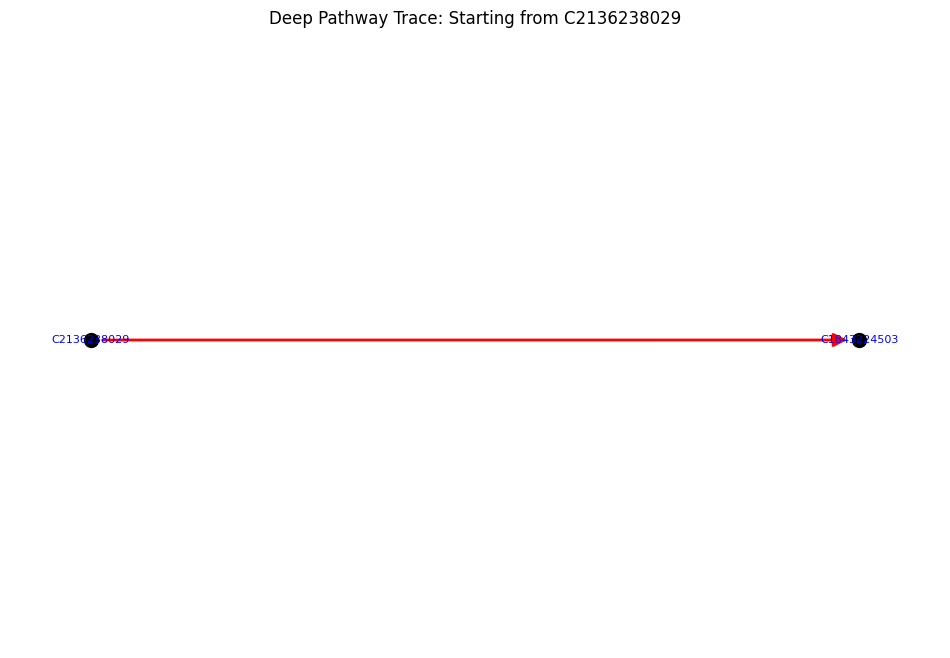

In [18]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# 1. 가장 사기가 빈번한 타겟 계좌 하나 선정
# (데이터 마트에서 사기 거래가 가장 많이 발생한 계좌를 찾습니다)
target_account = df_mart[df_mart['isFraud'] == 1]['nameOrig'].value_counts().idxmax()

# 2. 타겟 계좌와 연관된 3단계 경로 데이터 추출
# 타겟 계좌가 보낸 곳(1차), 그곳에서 또 보낸 곳(2차), 그 다음(3차)까지 추적
query_deep_path = f"""
WITH FirstStep AS (
    SELECT nameOrig, nameDest, amount, isFraud FROM PaySim WHERE nameOrig = '{target_account}'
),
SecondStep AS (
    SELECT p.nameOrig, p.nameDest, p.amount, p.isFraud 
    FROM PaySim p JOIN FirstStep f ON p.nameOrig = f.nameDest
),
ThirdStep AS (
    SELECT p.nameOrig, p.nameDest, p.amount, p.isFraud 
    FROM PaySim p JOIN SecondStep s ON p.nameOrig = s.nameDest
)
SELECT * FROM FirstStep UNION SELECT * FROM SecondStep UNION SELECT * FROM ThirdStep;
"""
df_deep = pd.read_sql(query_deep_path, engine)

# 3. 그래프 생성 및 시각화
G_deep = nx.from_pandas_edgelist(df_deep, 'nameOrig', 'nameDest', ['amount', 'isFraud'], create_using=nx.DiGraph())

plt.figure(figsize=(12, 8))
pos = nx.shell_layout(G_deep) # 계층 구조를 보기 위해 쉘 레이아웃 사용

edges = G_deep.edges(data=True)
edge_colors = ['red' if d['isFraud'] == 1 else 'skyblue' for u, v, d in edges]

nx.draw_networkx_nodes(G_deep, pos, node_size=100, node_color='black')
nx.draw_networkx_edges(G_deep, pos, edge_color=edge_colors, width=2, arrowsize=20)
nx.draw_networkx_labels(G_deep, pos, font_size=8, font_color='blue')

plt.title(f"Deep Pathway Trace: Starting from {target_account}")
plt.axis('off')
plt.show()

    - 해석
자금이 여러 단계를 거쳐 복잡하게 이동하는 것이 아니라 **송신자(A) → 수신자(B)**로 끝나는 단순 일회성 거래임

이는 PaySim 데이터의 사기 패턴이 매우 직선적이고 빠르게 현금화(CASH_OUT)되는 특징을 가지고 있기 때문.

네트워크 구조가 단순하다는 것은 돈을 받자마자 바로 뺀다는 뜻이므로, **속도(Velocity)**가 사기 탐지의 핵심 지표가 됨




    - 인사이트
네트워크가 파편화 됨
> 일회성 계좌 전략: 사기꾼들이 수사망을 피하기 위해 계좌를 재사용하지 않고, 한 번의 사기 후 바로 폐기하거나 현금화(CASH_OUT)한다는 증거입니다.
>
> 속도 중심의 범죄: 복잡한 세탁 경로를 거치기보다 **'송금(TRANSFER) → 즉시 인출'**의 2단계 프로세스를 선호합니다.
>
>분석 방향의 전환: 이제는 '누구와 연결되었는가(Network)'보다 **'얼마나 빨리, 이례적인 금액을 움직였는가(Velocity & Amount)'**가 탐지의 핵심이 됩니다.